In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights
from train_utils import train, predict
from diagnostic_tools import top_k_accuracy, per_class_accuracy,\
    count_params, entropy, model_calibration, show_errors, most_confused_classes,\
    most_inaccurate_k_classes
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 32

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=64, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

16980

# Model

In [6]:
from get_densenet201 import get_model

In [7]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_folder.class_to_idx)

In [8]:
model, criterion, optimizer = get_model(class_weights=torch.FloatTensor(w/w.sum()))

In [9]:
# number of params in the model
count_params(model)

18584704

# Train

In [10]:
n_epochs = 12
n_batches = ceil(train_size/batch_size)
# number of cycles
M = 1 
# total number of optimization steps
T = n_batches*n_epochs 
# initial learning rates
initial1 = 1e-2
initial2 = 1e-3
n_batches

531

In [11]:
# cyclical cosine annealing
# it changes the learning rate on every optimization step
# 1e-6 is the minimal learning rate
def lr_scheduler(optimizer, step):
    
    global initial1
    global initial2
    decay = np.cos(np.pi*((step - 1) % (T // M))/(T // M)) + 1.0
    
    # params of the last fc layer
    for param_group in optimizer.param_groups[:2]:
        param_group['lr'] = ((initial1 - 1e-6)*decay/2.0) + 1e-6
    
    # params of the last dense block
    for param_group in optimizer.param_groups[2:]:
        param_group['lr'] = ((initial2 - 1e-6)*decay/2.0) + 1e-6
    
    if (step - 1) % (T // M) == 0 and step != 1:
        print('lr is reset')
        
    return optimizer

In [12]:
%%time
all_losses, _ = train(
    model, criterion, optimizer, 
    train_iterator, n_epochs, n_batches, 
    val_iterator, validation_step=531, n_validation_batches=80, 
    saving_step=None, lr_scheduler=lr_scheduler
)
# epoch logloss    accuracy     top5_accuracy time  (first value: train, second value: val)

1.00  2.620 0.890  0.514 0.781  0.716 0.939  147.412
2.00  1.062 0.666  0.764 0.825  0.923 0.956  137.725
3.00  0.781 0.618  0.812 0.844  0.947 0.959  137.884
4.00  0.638 0.573  0.842 0.855  0.961 0.962  137.887
5.00  0.547 0.531  0.862 0.865  0.969 0.965  138.009
6.00  0.458 0.539  0.883 0.863  0.974 0.965  138.160
7.00  0.405 0.529  0.895 0.866  0.979 0.965  138.180
8.00  0.371 0.520  0.907 0.871  0.980 0.966  138.037
9.00  0.353 0.508  0.910 0.872  0.983 0.969  137.680
10.00  0.320 0.513  0.916 0.871  0.984 0.967  138.045
11.00  0.310 0.511  0.922 0.874  0.986 0.966  137.965
12.00  0.313 0.508  0.921 0.872  0.985 0.968  137.673
CPU times: user 22min 21s, sys: 4min 54s, total: 27min 16s
Wall time: 27min 44s


# Loss/epoch plots

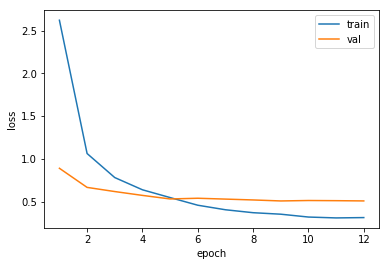

In [13]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

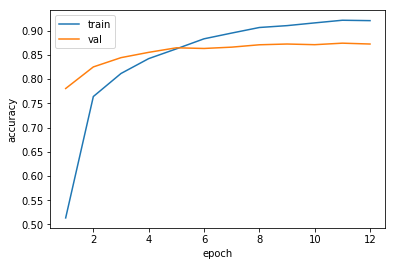

In [14]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

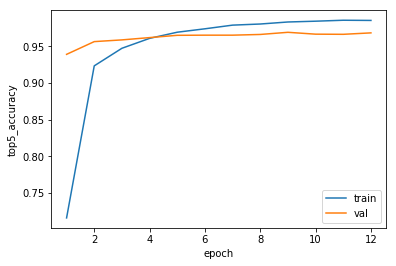

In [15]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Error analysis

### get human readable class names

In [16]:
# index to class name
decode = {val_folder.class_to_idx[k]: decode[int(k)] for k in val_folder.class_to_idx}

### get all predictions and all misclassified images 

In [17]:
val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=64, shuffle=False
)

In [18]:
val_predictions, val_true_targets,\
    erroneous_samples, erroneous_targets,\
    erroneous_predictions = predict(model, val_iterator_no_shuffle, return_erroneous=True)
# erroneous_samples: images that were misclassified
# erroneous_targets: their true labels
# erroneous_predictions: predictions for them

100%|██████████| 80/80 [00:38<00:00,  2.11it/s]


### number of misclassified images (there are overall 5120 images in the val dataset)

In [19]:
n_errors = len(erroneous_targets)
n_errors

653

### logloss and accuracies

In [20]:
log_loss(val_true_targets, val_predictions)

0.49012770656147736

In [21]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.87246093749999998

In [22]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.92949218749999996, 0.95039062500000004, 0.9599609375, 0.96835937500000002, 0.98222656249999996]


### entropy of predictions

In [23]:
hits = val_predictions.argmax(1) == val_true_targets

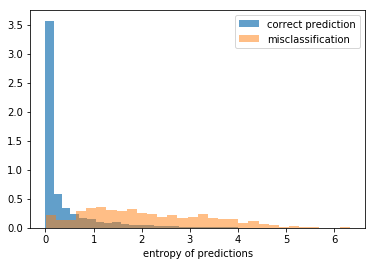

In [24]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

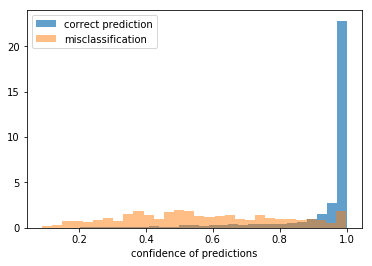

In [25]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

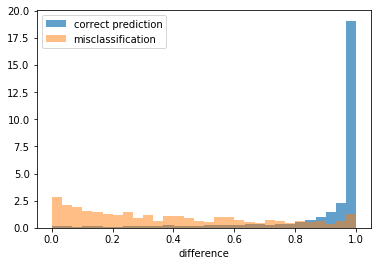

In [26]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

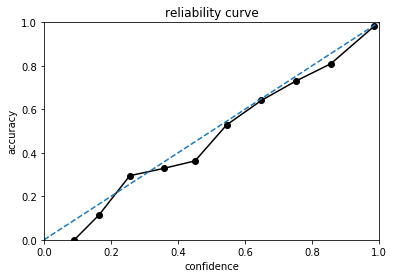

In [27]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

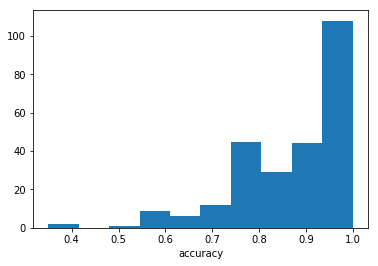

In [28]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc);
plt.xlabel('accuracy');

In [29]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

drinking-straw 0.35
playing-card 0.4
people 0.5
sword 0.55
rifle 0.55
soda-can 0.55
minotaur 0.55
tambourine 0.6
screwdriver 0.6
tennis-shoes 0.6
hot-dog 0.6
mailbox 0.6
bowling-ball 0.65
duck 0.65
coffin 0.65


### class accuracy vs. number of samples in the class

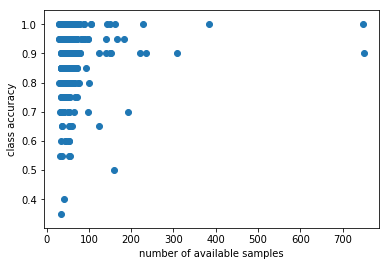

In [30]:
plt.scatter((1.0/w), per_class_acc);
plt.ylabel('class accuracy');
plt.xlabel('number of available samples');

### most confused pairs of classes

In [31]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=4
)
confused_pairs

[('beer-mug', 'coffee-mug'),
 ('hibiscus', 'iris'),
 ('kayak', 'canoe'),
 ('mandolin', 'electric-guitar'),
 ('mountain-bike', 'touring-bike'),
 ('sneaker', 'tennis-shoes'),
 ('swan', 'goose'),
 ('yo-yo', 'frisbee'),
 ('comet', 'galaxy'),
 ('duck', 'goose')]

### show some low entropy errors

In [32]:
erroneous_entropy = entropy(erroneous_predictions)
mean_entropy = erroneous_entropy.mean()
low_entropy = mean_entropy < erroneous_entropy
mean_entropy

2.0907557693776804

In [ ]:
show_errors(
    erroneous_samples[low_entropy], 
    erroneous_predictions[low_entropy], 
    erroneous_targets[low_entropy], 
    decode
)

### show some high entropy errors

In [ ]:
show_errors(
    erroneous_samples[~low_entropy], 
    erroneous_predictions[~low_entropy], 
    erroneous_targets[~low_entropy], 
    decode
)

# Save

In [35]:
model.cpu();
torch.save(model.state_dict(), 'model201.pytorch_state')